# Стохастический градиентный и координатный спуски

Для каждого задания указано количество баллов (если они оцениваются отдельно) + 1 балл за аккуратное и полное выполнение всего задания

In [1]:
# импортируем библиотеки
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn import *
%matplotlib inline

## Загрузка и подготовка данных

**Загрузите уже знакомый вам файл *Advertising.csv* как объект DataFrame.** 

In [2]:
#откроем данные
data = pd.read_csv('Advertising.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


**Проверьте, есть ли в данных пропуски и, если они есть - удалите их**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


В данных нет пропусков

**Преобразуйте ваши признаки в массивы NumPy и разделите их на переменные X (предикторы) и y(целевая переменная)** 

In [4]:
# матрица наблюдений X, вектор реальных значений целевой переменной y
X = np.array(data.drop('sales', axis=1))
y = np.array(data['sales']).reshape(200, 1)

## Координатный спуск (3 балла)

**Добавим единичный столбец для того, чтобы у нас был свободный коэффициент в уравнении регрессии:**

In [5]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Нормализуем данные: обычно это необходимо для корректной работы алгоритма**

In [6]:
X = X / np.sqrt(np.sum(np.square(X), axis=0))

**Реализуйте алгоритм координатного спуска:** (3 балла)

Ниже приведен алгоритм:

<a href="https://ibb.co/Th3BQFn"><img src="https://i.ibb.co/DK2DBS6/zascas.jpg" alt="zascas" border="0"></a>

Примечание: 1000 итераций здесь указаны для этого задания, на самом деле их может быть намного больше, нет детерменированного значения.

Вам необходимо реализовать координатный спуск, и вывести веса в модели линейной регрессии.

In [7]:
def coordinate_descent(X, y, num_iters=1000, precision=1e-9):
    # нулевой вектор весов
    n = X.shape[1]
    w = np.zeros((n, 1))
    iteration_count = num_iters

    for i in range(num_iters):
        for j in range(n):
            # Вычисляем прогноз без j-ого фактора
            h = (X[:, 0:j] @ w[0:j]) + (X[:, j+1:] @ w[j+1:])
            # Обновляем новое значение k-ого коэффициента
            w[j] =  (X[:,j].T @ (y - h))
        
        # Вычисляем функцию потерь    
        r = sum((X@w) - y) ** 2/(len(y))
        # если достигли заданной точности, выходим из цикла
        if r < precision:
            iteration_count = i + 1 # количество итераций
            break
        
    return w, r, iteration_count
    
w, cost, iters = coordinate_descent(X, y)   
print(f'Значение функции потерь: {cost}')
print(f'Вектор весов:\n {w}')
print(f'Количество итераций: {iters}')

Значение функции потерь: [6.94871853e-10]
Вектор весов:
 [[ 41.56224451]
 [110.13144649]
 [ 73.5286098 ]
 [ -0.55012919]]
Количество итераций: 54


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y, (X@w))
print(f'Среднеквадратичная ошибка: {mse}')
mae = mean_absolute_error(y, (X@w))
print(f'Средняя абсолютная ошибка: {mae}')

Среднеквадратичная ошибка: 2.7841263145213304
Средняя абсолютная ошибка: 1.252010718242513


Сравните результаты с реализацией линейной регрессии из библиотеки sklearn:

In [9]:
from sklearn.linear_model import LinearRegression
 
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
 
print(model.coef_)

[[ 41.56217205 110.13144155  73.52860638  -0.55006384]]


Коэффициенты совпадают с точностью до тысячных. Для расчета достаточно порядка 50 итераций.

## Стохастический градиентный спуск (6 баллов)

**Отмасштабируйте столбцы исходной матрицы *X* (которую мы не нормализовали еще!). Для того, чтобы это сделать, надо вычесть из каждого значения среднее и разделить на стандартное отклонение** (0.5 баллов)

In [10]:
X = np.array(data.drop('sales', axis=1))
y = np.array(data['sales']).reshape(200, 1)

X = (X-X.mean())/X.std()

**Добавим единичный столбец**

In [11]:
X = np.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])

**Создайте функцию mse_error для вычисления среднеквадратичной ошибки, принимающую два аргумента: реальные значения и предсказывающие, и возвращающую значение mse** (0.5 балла)

In [12]:
def mse_error(y, y_pred):
    mse = ((y - y_pred) ** 2).mean()
    return mse

**Сделайте наивный прогноз: предскажите продажи средним значением. После этого рассчитайте среднеквадратичную ошибку для этого прогноза** (0.5 балла)

In [13]:
y_mean = np.ones((200, 1))*y.mean()
print(mse_error(y, y_mean))

27.085743750000002


**Создайте функцию *lin_pred*, которая может по матрице предикторов *X* и вектору весов линейной модели *w* получить вектор прогнозов** (0.5 балла)

In [14]:
def lin_pred(X, w):
    return X@w

**Создайте функцию *stoch_grad_step* для реализации шага стохастического градиентного спуска. (1.5 балла) 
Функция должна принимать на вход следующие аргументы:**
* матрицу *X*
* вектора *y* и *w*
* число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов
* число *$\eta$* (eta) - шаг градиентного спуска

Результатом будет вектор обновленных весов

Шаг для стохастического градиентного спуска выглядит следующим образом:

$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$

Для того, чтобы написать функцию, нужно сделать следующее:
    
*  посчитать направление изменения: умножить объект обучающей выборки на 2 и на разницу между предсказанным значением и реальным, а потом поделить на количество элементов в выборке.
* вернуть разницу между вектором весов и направлением изменения, умноженным на шаг градиентного спуска

In [15]:
def stoch_grad_step(X, y, w, train_index, eta):
    
    y = y.reshape(200, 1)
    # Compute the prediction for the selected instance
    y_pred_train = lin_pred(X[train_index].reshape(1, -1), w)

    # Calculate the gradient direction for the selected instance
    w_new = w - 2 * eta * (X[train_index] * (y_pred_train - y[train_index, 0]) / len(X))
    
    return w_new

**Создайте функцию *stochastic_gradient_descent*, для реализации стохастического градиентного спуска (2.5 балла)**

**Функция принимает на вход следующие аргументы:**
- Матрицу признаков X
- Целевую переменнную
- Изначальную точку (веса модели)
- Параметр, определяющий темп обучения
- Максимальное число итераций
- Евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,при котором алгоритм прекращает работу 

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

Алгоритм сследующий:
    
* Инициализируйте расстояние между векторами весов на соседних итерациях большим числом (можно бесконечностью)
* Создайте пустой список для фиксации ошибок
* Создайте счетчик итераций
* Реализуйте основной цикл обучения пока расстояние между векторами весов больше того, при котором надо прекратить работу (когда расстояния станут слишком маленькими - значит, мы застряли в одном месте) и количество итераций меньше максимально разрешенного: сгенерируйте случайный индекс, запишите текущую ошибку в вектор ошибок, запишите в переменную текущий шаг стохастического спуска с использованием функции, написанной ранее. Далее рассчитайте текущее расстояние между векторами весов и прибавьте к счетчику итераций 1.
* Верните вектор весов и вектор ошибок

In [16]:
def stochastic_gradient_descent(X, y, w, eta, max_iter=100000, eps=1e-5):
    errors = [] # список для ошибок
    w_dist = 10000 # расстояние между векторами весов
    i = 0 # счетчик итераций
    
    while True:
        # случайный индекс
        k = np.random.randint(X.shape[0])
        # шаг стохастического спуска
        w_curr = stoch_grad_step(X, y, w, k, eta)
        i += 1
        # расстояние между векторами весов, новым и предыдущим
        w_dist = np.linalg.norm(w - w_curr)
        # обновление вектора весов
        w = w_curr
        # текущая ошибка
        r = mse_error(y, lin_pred(X, w))
        #r = mean_squared_error(y, lin_pred(X, w))
        errors.append(r)
        # если достигли заданной точности или максимального числа итераций, выходим из цикла
        if w_dist<=eps or i>=max_iter:
            break
        
    return (w, errors)

 **Запустите $10^5$ итераций стохастического градиентного спуска. Укажите вектор начальных весов, состоящий из нулей. Можете поэкспериментировать с параметром, отвечающим за темп обучения.**

In [25]:
# нулевой вектор весов
n = X.shape[1]
w0 = np.zeros(n)

# будем сравнивать среднеквадратичные ошибки на последней итерации при различных темпах обучения
errors = {}
for eta in np.arange(0.05, 1.4, 0.05):
    # запускаем стохастический градиентный спуск при текущем параметре eta
    w, mse = stochastic_gradient_descent(X, y, w0, eta)
    errors[mse[-1]] = eta

# выбираем темп, давший наименьшую mse
eta_min = round(errors[min(errors.keys())], 2)    
print(f'Среднеквадратичная ошибка минимальна: {min(errors.keys()):.3f} при темпе обучения: {eta_min}')

Среднеквадратичная ошибка минимальна: 2.830 при темпе обучения: 1.15


In [26]:
w, error = stochastic_gradient_descent(X, y, w0, eta_min)
print(f'Среднеквадратичная ошибка: {error[-1]:.3f}')
print(f'Вектор весов: {w}')
print(f'Число итераций: {len(error)}')

Среднеквадратичная ошибка: 2.937
Вектор весов: [17.71179873  3.78762443 13.09074555  0.34236894]
Число итераций: 8906


**Постройте график зависимости ошибки от номера итерации**

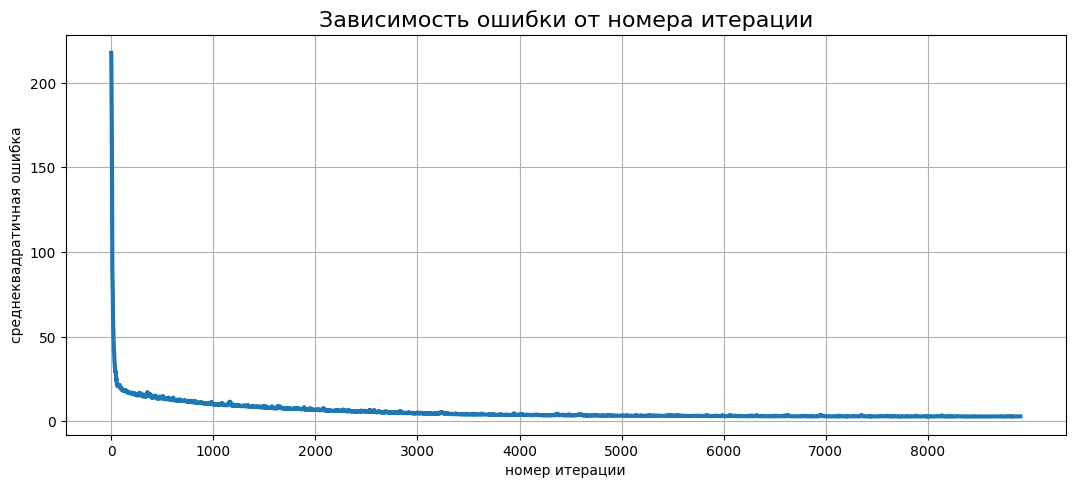

In [27]:
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
#iters = np.arange(1, len(errors)+1)
axes.plot(error, lw=3)
#установка параметров отображения
axes.set_title('Зависимость ошибки от номера итерации', fontsize=16)
axes.set_xlabel('номер итерации')
axes.set_ylabel('среднеквадратичная ошибка')
axes.set_xticks(range(0, len(error), 1000))
#axes.xaxis.set_tick_params(rotation=30)
axes.grid()

**Выведите вектор весов, к которому сошелся метод.**

In [31]:
print(f'Вектор весов: {w}')

Вектор весов: [17.71179873  3.78762443 13.09074555  0.34236894]


**Выведите среднеквадратичную ошибку на последней итерации.**

In [28]:
print(f'Среднеквадратичная ошибка: {error[-1]:.3f}')

Среднеквадратичная ошибка: 2.937


In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y, lin_pred(X, w))
print(f'Среднеквадратичная ошибка: {mse:.3f}')
mae = mean_absolute_error(y, lin_pred(X, w))
print(f'Средняя абсолютная ошибка: {mae:.3f}')

Среднеквадратичная ошибка: 2.937
Средняя абсолютная ошибка: 1.305


## Бонусное задание

**Выберите в документации класс, подходящий для вашей задачи, и обучите стохастический градиентный спуск.
Оцените качество с помощью среднеквадратичной ошибки и сравните результат с результатом алгоритма, реализованного вами самостоятельно.
В одном из предыдущих модулей качество решения задачи регрессии оценивалось с помощью ещё одной метрики. Найдите её реализацию в библиотеке sklearn и оцените качество полученной модели.**

In [37]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# исправим размерность y
y = y.reshape(200)

# разделим данные на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# модель стохастического градиентного спуска SGDRegressor 
model = SGDRegressor(fit_intercept=False)
model.fit(X_train, y_train)
print(f'Вектор весов: {model.coef_}')
print(f'Число итераций: {model.n_iter_}')

# оценки качества модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка: {mse:.3f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Средняя абсолютная ошибка: {mae:.3f}')

# среднее значение метрики MAPE, кросс-валидация на пяти фолдах
cv_results = cross_validate(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))


Вектор весов: [17.09314062  3.50176412 10.99678286  1.08150916]
Число итераций: 533
Среднеквадратичная ошибка: 3.541
Средняя абсолютная ошибка: 1.531
MAPE на тренировочных фолдах: 13.29 %
MAPE на валидационных фолдах: 14.10 %


In [38]:
print(f'Расстояние между полученными векторам коэффициентов: {np.linalg.norm(w-model.coef_):.3f}')

Расстояние между полученными векторам коэффициентов: 2.323


### Выводы

Реализованы координатный спуск и стохастический градиентный спуск. Также с использованием библиотеки sklearn обучена модель стохастического градиентного спуска SGDRegressor. Готовая реализация дает стабильный результат весов и достаточно малые ошибки MSE и MAE. Значения метрики MAPE на тренировочных и валидационных фолдах не отличаются значительно. При этом в настройках модели использованы значения параметров по умолчанию, метод дает возможность подбирать параметры для более точных результатов. 

Алгоритм координатного спуска, реализованный в домашней работе, показывает хорошее качество. Коэффициенты, полученные в этой модели и в готовой модели линейной регрессии из sklearn, совпадают с точностью до тысячных. Для расчета достаточно чуть больше 50 итераций.

Результаты алгоритма стохастического градиентного спуска непостоянны, по-видимому, из-за большой степени случайности. Количество итераций и среднеквадратичная ошибка разнятся при повтором запуске ячейки кода. Наблюдается некоторое расхождение между коэффициентами этой модели и модели готового алгоритма SGDRegressor. Возможно, неточности связаны с тем, что в реализованном алгоритме не масштабируется параметр eta и обучающие данные не перетасовываются после каждой эпохи, в отличие от SGDRegressor, где это установлено по умолчанию. Тем не менее, с помошью такого довольно простого алгоритма возможно получить неплохую точность результата: ошибки MSE и MAE того же порядка, что при применении sklearn.
